## Personalized Learning (Localized Learning?)

#### This notebook includes the following online models;
1. A single global model with all data
2. Multiple local models (starting from a single global model)
   1. that are updated with new data
   2. that exchanges data in clusters
   3. that exchanges parameters in clusters

  
#### The dataset that is used for this project is [CIFAR-100 dataset][1]
* Has 100 classes containing 600 images each

#### New data are fed by the following rules;
1. Distributed, according to superclasses
  * Clusters will only be updated with data that belongs to a specific superclass
  * We update the NN by
    1. Changing all parameters of the NN
    2. Only changing the last few layers, as in many MTL models
2. Randomly (why?)

#### We expect to find an answer to the following research questions with this project;
1. If models are updated with data (or parameters) that are shared within a cluster, can the model perform good enough with the labels that count?
  * For example, the performance of the cluster that are updated with "Vehicles" superclass is only assessed with the labels that corresponds to the superclass.
  
[1]: https://www.cs.toronto.edu/~kriz/cifar.html

#### Questions

Retraining: how does it work <br>
How do we compare these models?


### Implementation with Custom Neural Network and MNIST dataset

In [37]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [38]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [39]:
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [40]:
tf.__version__

'2.1.0'

In [41]:
from numpy.random import seed
seed(123)

In [42]:
# Hyperparameters
batch_size = 50
num_classes = 10
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

#### Load MNIST dataset

In [43]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [44]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [45]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [46]:
x_train1 = x_train[-700:]
y_train1 = y_train[-700:]
x_train2 = x_train[:700]
y_train2 = y_train[:700]

In [47]:
# Reserve 10,000 samples for validation
x_val1 = x_train1[-100:]
y_val1 = y_train1[-100:]
x_train1 = x_train1[:-100]
y_train1 = y_train1[:-100]

x_val2 = x_train2[-100:]
y_val2 = y_train2[-100:]
x_train2 = x_train2[:-100]
y_train2 = y_train2[:-100]

In [48]:
print('x_train shape:', x_train1.shape)
print(x_train1.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (600, 28, 28, 1)
600 train samples
10000 test samples


In [49]:
# convert class vectors to binary class matrices
y_train1 = keras.utils.to_categorical(y_train1, num_classes)
y_val1 = keras.utils.to_categorical(y_val1, num_classes)
y_train2 = keras.utils.to_categorical(y_train2, num_classes)
y_val2 = keras.utils.to_categorical(y_val2, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Define models and compile & fit function

In [50]:
def custom_model():
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [51]:
def compile_model(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [52]:
def compile_model_lr(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [53]:
def fit_model1(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train1, y_train1,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_val1, y_val1),
                      shuffle=True, callbacks=[tensorboard_callback])

In [54]:
def fit_model2(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train2, y_train2,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_val2, y_val2),
                      shuffle=True, callbacks=[tensorboard_callback])

In [55]:
model1 = custom_model()
model1_clone = tf.keras.models.clone_model(model1)
model1_clone.set_weights(model1.get_weights())
model2 = tf.keras.models.clone_model(model1) # different initialization

### Make a spectrum of models according to purturbations. Linear Interpolation with a granularity of 5%

In [56]:
import numpy as np
pi_list = list(np.arange(0, 1.05, 0.05)) # P for perturbations

weights = [model1.get_weights(), model2.get_weights()]
model_weights_list = list()
for pi in pi_list:
    agg_weights = list()
    for weights_list_tuple in zip(*weights):
        agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - pi, pi]) for w in zip(*weights_list_tuple)]))
    model_weights_list.append(agg_weights)

In [57]:
model_list = list()
for _ in range(len(pi_list)):
    model_list.append(tf.keras.models.clone_model(model1))

In [58]:
for i in range(len(model_list)):
    model_list[i].set_weights(model_weights_list[i])

In [59]:
model1.count_params()

199210

In [60]:
import semantic_drift

In [61]:
dist_list = []
for m in model_list:
    dist_list.append(semantic_drift.l2_distance(model1, m))

### Now we have a spectrum of models from model1 to model2

In [62]:
compile_model(model1)
fit_model1(model1, 240)

for m in model_list:
    compile_model(m)
    fit_model2(m, 240)

Training date and time : 
2020-04-09 21:01:40
Train on 600 samples, validate on 100 samples
Epoch 1/240
600/600 [==============================] - 0s 649us/sample - loss: 0.0902 - accuracy: 0.1383 - val_loss: 0.0898 - val_accuracy: 0.1900
Epoch 2/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0895 - accuracy: 0.1717 - val_loss: 0.0894 - val_accuracy: 0.2500
Epoch 3/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0889 - accuracy: 0.2033 - val_loss: 0.0890 - val_accuracy: 0.2700
Epoch 4/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0883 - accuracy: 0.2350 - val_loss: 0.0887 - val_accuracy: 0.2700
Epoch 5/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0878 - accuracy: 0.2767 - val_loss: 0.0883 - val_accuracy: 0.3000
Epoch 6/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0872 - accuracy: 0.3067 - val_loss: 0.0879 - val_accuracy: 0.2900
Epoch 7/240
600/600 [=========

600/600 [==============================] - 0s 105us/sample - loss: 0.0313 - accuracy: 0.8467 - val_loss: 0.0488 - val_accuracy: 0.7200
Epoch 57/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0305 - accuracy: 0.8517 - val_loss: 0.0482 - val_accuracy: 0.7400
Epoch 58/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0297 - accuracy: 0.8583 - val_loss: 0.0476 - val_accuracy: 0.7400
Epoch 59/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0288 - accuracy: 0.8600 - val_loss: 0.0470 - val_accuracy: 0.7400
Epoch 60/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0280 - accuracy: 0.8733 - val_loss: 0.0464 - val_accuracy: 0.7500
Epoch 61/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0271 - accuracy: 0.8767 - val_loss: 0.0458 - val_accuracy: 0.7500
Epoch 62/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0263 - accuracy: 0.8850 - val_loss: 0.0452 - v

Epoch 112/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0091 - accuracy: 0.9650 - val_loss: 0.0304 - val_accuracy: 0.8100
Epoch 113/240
600/600 [==============================] - 0s 90us/sample - loss: 0.0090 - accuracy: 0.9650 - val_loss: 0.0303 - val_accuracy: 0.8100
Epoch 114/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0088 - accuracy: 0.9650 - val_loss: 0.0302 - val_accuracy: 0.8100
Epoch 115/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0087 - accuracy: 0.9650 - val_loss: 0.0302 - val_accuracy: 0.8100
Epoch 116/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0087 - accuracy: 0.9650 - val_loss: 0.0301 - val_accuracy: 0.8200
Epoch 117/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0085 - accuracy: 0.9650 - val_loss: 0.0298 - val_accuracy: 0.8200
Epoch 118/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0084 - accuracy: 0.9650 - va

600/600 [==============================] - 0s 99us/sample - loss: 0.0054 - accuracy: 0.9767 - val_loss: 0.0255 - val_accuracy: 0.8500
Epoch 168/240
600/600 [==============================] - 0s 90us/sample - loss: 0.0053 - accuracy: 0.9783 - val_loss: 0.0254 - val_accuracy: 0.8500
Epoch 169/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0053 - accuracy: 0.9767 - val_loss: 0.0253 - val_accuracy: 0.8500
Epoch 170/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0053 - accuracy: 0.9783 - val_loss: 0.0253 - val_accuracy: 0.8500
Epoch 171/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0052 - accuracy: 0.9767 - val_loss: 0.0252 - val_accuracy: 0.8500
Epoch 172/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0052 - accuracy: 0.9783 - val_loss: 0.0252 - val_accuracy: 0.8500
Epoch 173/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0052 - accuracy: 0.9783 - val_loss: 0.0252

600/600 [==============================] - 0s 95us/sample - loss: 0.0039 - accuracy: 0.9800 - val_loss: 0.0232 - val_accuracy: 0.8600
Epoch 223/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0039 - accuracy: 0.9800 - val_loss: 0.0231 - val_accuracy: 0.8600
Epoch 224/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0039 - accuracy: 0.9800 - val_loss: 0.0231 - val_accuracy: 0.8600
Epoch 225/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0039 - accuracy: 0.9800 - val_loss: 0.0230 - val_accuracy: 0.8600
Epoch 226/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0038 - accuracy: 0.9800 - val_loss: 0.0230 - val_accuracy: 0.8600
Epoch 227/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0038 - accuracy: 0.9800 - val_loss: 0.0230 - val_accuracy: 0.8600
Epoch 228/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0038 - accuracy: 0.9800 - val_loss: 0.023

Epoch 37/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0629 - accuracy: 0.6100 - val_loss: 0.0682 - val_accuracy: 0.5400
Epoch 38/240
600/600 [==============================] - 0s 109us/sample - loss: 0.0618 - accuracy: 0.6150 - val_loss: 0.0673 - val_accuracy: 0.5600
Epoch 39/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0607 - accuracy: 0.6200 - val_loss: 0.0665 - val_accuracy: 0.5600
Epoch 40/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0597 - accuracy: 0.6200 - val_loss: 0.0658 - val_accuracy: 0.5600
Epoch 41/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0586 - accuracy: 0.6250 - val_loss: 0.0650 - val_accuracy: 0.5600
Epoch 42/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0576 - accuracy: 0.6300 - val_loss: 0.0642 - val_accuracy: 0.5700
Epoch 43/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0567 - accuracy: 0.6350 - val_lo

600/600 [==============================] - 0s 97us/sample - loss: 0.0250 - accuracy: 0.8717 - val_loss: 0.0413 - val_accuracy: 0.7200
Epoch 93/240
600/600 [==============================] - 0s 109us/sample - loss: 0.0246 - accuracy: 0.8750 - val_loss: 0.0410 - val_accuracy: 0.7200
Epoch 94/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0243 - accuracy: 0.8783 - val_loss: 0.0408 - val_accuracy: 0.7200
Epoch 95/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0239 - accuracy: 0.8833 - val_loss: 0.0405 - val_accuracy: 0.7200
Epoch 96/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0236 - accuracy: 0.8833 - val_loss: 0.0403 - val_accuracy: 0.7200
Epoch 97/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0232 - accuracy: 0.8833 - val_loss: 0.0400 - val_accuracy: 0.7300
Epoch 98/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0229 - accuracy: 0.8833 - val_loss: 0.0397 - val

600/600 [==============================] - 0s 98us/sample - loss: 0.0132 - accuracy: 0.9417 - val_loss: 0.0306 - val_accuracy: 0.7600
Epoch 148/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0131 - accuracy: 0.9433 - val_loss: 0.0304 - val_accuracy: 0.7800
Epoch 149/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0129 - accuracy: 0.9433 - val_loss: 0.0304 - val_accuracy: 0.7800
Epoch 150/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0128 - accuracy: 0.9417 - val_loss: 0.0302 - val_accuracy: 0.7800
Epoch 151/240
600/600 [==============================] - 0s 90us/sample - loss: 0.0127 - accuracy: 0.9417 - val_loss: 0.0301 - val_accuracy: 0.7800
Epoch 152/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0126 - accuracy: 0.9450 - val_loss: 0.0300 - val_accuracy: 0.7800
Epoch 153/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0125 - accuracy: 0.9450 - val_loss: 0.0299

600/600 [==============================] - 0s 97us/sample - loss: 0.0083 - accuracy: 0.9650 - val_loss: 0.0268 - val_accuracy: 0.7900
Epoch 203/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0083 - accuracy: 0.9650 - val_loss: 0.0267 - val_accuracy: 0.7900
Epoch 204/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0082 - accuracy: 0.9650 - val_loss: 0.0266 - val_accuracy: 0.7900
Epoch 205/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0081 - accuracy: 0.9650 - val_loss: 0.0267 - val_accuracy: 0.7900
Epoch 206/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0081 - accuracy: 0.9650 - val_loss: 0.0266 - val_accuracy: 0.7900
Epoch 207/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0080 - accuracy: 0.9650 - val_loss: 0.0266 - val_accuracy: 0.7900
Epoch 208/240
600/600 [==============================] - 0s 108us/sample - loss: 0.0080 - accuracy: 0.9650 - val_loss: 0.0265 

Epoch 17/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0845 - accuracy: 0.5017 - val_loss: 0.0850 - val_accuracy: 0.4500
Epoch 18/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0840 - accuracy: 0.5100 - val_loss: 0.0846 - val_accuracy: 0.4500
Epoch 19/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0835 - accuracy: 0.5150 - val_loss: 0.0842 - val_accuracy: 0.4700
Epoch 20/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0829 - accuracy: 0.5283 - val_loss: 0.0838 - val_accuracy: 0.4700
Epoch 21/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0823 - accuracy: 0.5350 - val_loss: 0.0833 - val_accuracy: 0.4700
Epoch 22/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0817 - accuracy: 0.5450 - val_loss: 0.0828 - val_accuracy: 0.4700
Epoch 23/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0811 - accuracy: 0.5500 - val_loss: 

Epoch 73/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0381 - accuracy: 0.7750 - val_loss: 0.0507 - val_accuracy: 0.6700
Epoch 74/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0375 - accuracy: 0.7783 - val_loss: 0.0504 - val_accuracy: 0.6800
Epoch 75/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0369 - accuracy: 0.7817 - val_loss: 0.0499 - val_accuracy: 0.6800
Epoch 76/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0362 - accuracy: 0.7933 - val_loss: 0.0495 - val_accuracy: 0.6800
Epoch 77/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0356 - accuracy: 0.7967 - val_loss: 0.0491 - val_accuracy: 0.6800
Epoch 78/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0350 - accuracy: 0.7967 - val_loss: 0.0488 - val_accuracy: 0.6800
Epoch 79/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0345 - accuracy: 0.8017 - val_loss: 

600/600 [==============================] - 0s 98us/sample - loss: 0.0176 - accuracy: 0.9117 - val_loss: 0.0348 - val_accuracy: 0.7500
Epoch 129/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0174 - accuracy: 0.9117 - val_loss: 0.0345 - val_accuracy: 0.7500
Epoch 130/240
600/600 [==============================] - 0s 110us/sample - loss: 0.0173 - accuracy: 0.9150 - val_loss: 0.0344 - val_accuracy: 0.7500
Epoch 131/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0171 - accuracy: 0.9150 - val_loss: 0.0342 - val_accuracy: 0.7500
Epoch 132/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0169 - accuracy: 0.9167 - val_loss: 0.0340 - val_accuracy: 0.7500
Epoch 133/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0167 - accuracy: 0.9183 - val_loss: 0.0338 - val_accuracy: 0.7400
Epoch 134/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0165 - accuracy: 0.9233 - val_loss: 0.0337 

600/600 [==============================] - 0s 97us/sample - loss: 0.0106 - accuracy: 0.9517 - val_loss: 0.0284 - val_accuracy: 0.7900
Epoch 184/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0105 - accuracy: 0.9533 - val_loss: 0.0284 - val_accuracy: 0.7900
Epoch 185/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0104 - accuracy: 0.9533 - val_loss: 0.0283 - val_accuracy: 0.7900
Epoch 186/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0103 - accuracy: 0.9533 - val_loss: 0.0284 - val_accuracy: 0.7900
Epoch 187/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0103 - accuracy: 0.9533 - val_loss: 0.0283 - val_accuracy: 0.7900
Epoch 188/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0102 - accuracy: 0.9533 - val_loss: 0.0282 - val_accuracy: 0.7900
Epoch 189/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0101 - accuracy: 0.9533 - val_loss: 0.0282 

600/600 [==============================] - 0s 97us/sample - loss: 0.0071 - accuracy: 0.9700 - val_loss: 0.0263 - val_accuracy: 0.7900
Epoch 239/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0070 - accuracy: 0.9683 - val_loss: 0.0263 - val_accuracy: 0.7900
Epoch 240/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0070 - accuracy: 0.9683 - val_loss: 0.0263 - val_accuracy: 0.7900
Training date and time : 
2020-04-09 21:02:27
Train on 600 samples, validate on 100 samples
Epoch 1/240
600/600 [==============================] - 0s 657us/sample - loss: 0.0902 - accuracy: 0.1117 - val_loss: 0.0895 - val_accuracy: 0.1600
Epoch 2/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0899 - accuracy: 0.1300 - val_loss: 0.0893 - val_accuracy: 0.1600
Epoch 3/240
600/600 [==============================] - 0s 116us/sample - loss: 0.0896 - accuracy: 0.1483 - val_loss: 0.0891 - val_accuracy: 0.1800
Epoch 4/240
600/600 [=================

600/600 [==============================] - 0s 92us/sample - loss: 0.0574 - accuracy: 0.6317 - val_loss: 0.0640 - val_accuracy: 0.5900
Epoch 54/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0566 - accuracy: 0.6400 - val_loss: 0.0633 - val_accuracy: 0.5900
Epoch 55/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0557 - accuracy: 0.6400 - val_loss: 0.0627 - val_accuracy: 0.5900
Epoch 56/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0549 - accuracy: 0.6467 - val_loss: 0.0620 - val_accuracy: 0.6200
Epoch 57/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0541 - accuracy: 0.6483 - val_loss: 0.0614 - val_accuracy: 0.6200
Epoch 58/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0532 - accuracy: 0.6500 - val_loss: 0.0607 - val_accuracy: 0.6200
Epoch 59/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0524 - accuracy: 0.6517 - val_loss: 0.0601 - val

600/600 [==============================] - 0s 103us/sample - loss: 0.0250 - accuracy: 0.8817 - val_loss: 0.0410 - val_accuracy: 0.7100
Epoch 109/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0247 - accuracy: 0.8783 - val_loss: 0.0408 - val_accuracy: 0.7100
Epoch 110/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0244 - accuracy: 0.8800 - val_loss: 0.0404 - val_accuracy: 0.7100
Epoch 111/240
600/600 [==============================] - 0s 87us/sample - loss: 0.0240 - accuracy: 0.8800 - val_loss: 0.0402 - val_accuracy: 0.7300
Epoch 112/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0237 - accuracy: 0.8833 - val_loss: 0.0399 - val_accuracy: 0.7300
Epoch 113/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0234 - accuracy: 0.8817 - val_loss: 0.0397 - val_accuracy: 0.7300
Epoch 114/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0231 - accuracy: 0.8850 - val_loss: 0.0394

600/600 [==============================] - 0s 92us/sample - loss: 0.0138 - accuracy: 0.9383 - val_loss: 0.0310 - val_accuracy: 0.7600
Epoch 164/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0137 - accuracy: 0.9383 - val_loss: 0.0309 - val_accuracy: 0.7600
Epoch 165/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0136 - accuracy: 0.9383 - val_loss: 0.0308 - val_accuracy: 0.7600
Epoch 166/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0135 - accuracy: 0.9383 - val_loss: 0.0307 - val_accuracy: 0.7700
Epoch 167/240
600/600 [==============================] - 0s 88us/sample - loss: 0.0133 - accuracy: 0.9383 - val_loss: 0.0305 - val_accuracy: 0.7700
Epoch 168/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0132 - accuracy: 0.9417 - val_loss: 0.0304 - val_accuracy: 0.7700
Epoch 169/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0131 - accuracy: 0.9383 - val_loss: 0.030

600/600 [==============================] - 0s 99us/sample - loss: 0.0089 - accuracy: 0.9633 - val_loss: 0.0272 - val_accuracy: 0.7900
Epoch 219/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0088 - accuracy: 0.9633 - val_loss: 0.0272 - val_accuracy: 0.7900
Epoch 220/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0088 - accuracy: 0.9633 - val_loss: 0.0272 - val_accuracy: 0.7900
Epoch 221/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0087 - accuracy: 0.9633 - val_loss: 0.0271 - val_accuracy: 0.7900
Epoch 222/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0087 - accuracy: 0.9633 - val_loss: 0.0271 - val_accuracy: 0.7900
Epoch 223/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0086 - accuracy: 0.9633 - val_loss: 0.0271 - val_accuracy: 0.7900
Epoch 224/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0085 - accuracy: 0.9633 - val_loss: 0.0270 

600/600 [==============================] - 0s 89us/sample - loss: 0.0794 - accuracy: 0.5683 - val_loss: 0.0810 - val_accuracy: 0.4700
Epoch 34/240
600/600 [==============================] - 0s 85us/sample - loss: 0.0788 - accuracy: 0.5633 - val_loss: 0.0805 - val_accuracy: 0.4700
Epoch 35/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0781 - accuracy: 0.5633 - val_loss: 0.0799 - val_accuracy: 0.4600
Epoch 36/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0773 - accuracy: 0.5633 - val_loss: 0.0793 - val_accuracy: 0.4600
Epoch 37/240
600/600 [==============================] - 0s 90us/sample - loss: 0.0766 - accuracy: 0.5617 - val_loss: 0.0787 - val_accuracy: 0.4600
Epoch 38/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0758 - accuracy: 0.5617 - val_loss: 0.0781 - val_accuracy: 0.4600
Epoch 39/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0750 - accuracy: 0.5617 - val_loss: 0.0775 - val_a

Epoch 89/240
600/600 [==============================] - 0s 85us/sample - loss: 0.0365 - accuracy: 0.7917 - val_loss: 0.0496 - val_accuracy: 0.6800
Epoch 90/240
600/600 [==============================] - 0s 90us/sample - loss: 0.0360 - accuracy: 0.7950 - val_loss: 0.0493 - val_accuracy: 0.6900
Epoch 91/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0354 - accuracy: 0.7967 - val_loss: 0.0490 - val_accuracy: 0.6900
Epoch 92/240
600/600 [==============================] - 0s 90us/sample - loss: 0.0349 - accuracy: 0.7967 - val_loss: 0.0486 - val_accuracy: 0.6900
Epoch 93/240
600/600 [==============================] - 0s 89us/sample - loss: 0.0344 - accuracy: 0.7983 - val_loss: 0.0482 - val_accuracy: 0.6900
Epoch 94/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0340 - accuracy: 0.8033 - val_loss: 0.0479 - val_accuracy: 0.6900
Epoch 95/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0335 - accuracy: 0.8050 - val_loss: 0

600/600 [==============================] - 0s 85us/sample - loss: 0.0184 - accuracy: 0.9050 - val_loss: 0.0352 - val_accuracy: 0.7500
Epoch 145/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0182 - accuracy: 0.9050 - val_loss: 0.0350 - val_accuracy: 0.7500
Epoch 146/240
600/600 [==============================] - 0s 88us/sample - loss: 0.0180 - accuracy: 0.9100 - val_loss: 0.0349 - val_accuracy: 0.7500
Epoch 147/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0179 - accuracy: 0.9067 - val_loss: 0.0347 - val_accuracy: 0.7500
Epoch 148/240
600/600 [==============================] - 0s 89us/sample - loss: 0.0177 - accuracy: 0.9133 - val_loss: 0.0345 - val_accuracy: 0.7500
Epoch 149/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0175 - accuracy: 0.9100 - val_loss: 0.0344 - val_accuracy: 0.7600
Epoch 150/240
600/600 [==============================] - 0s 88us/sample - loss: 0.0174 - accuracy: 0.9117 - val_loss: 0.0342 -

600/600 [==============================] - 0s 91us/sample - loss: 0.0113 - accuracy: 0.9483 - val_loss: 0.0289 - val_accuracy: 0.7900
Epoch 200/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0112 - accuracy: 0.9500 - val_loss: 0.0288 - val_accuracy: 0.7900
Epoch 201/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0111 - accuracy: 0.9500 - val_loss: 0.0288 - val_accuracy: 0.7900
Epoch 202/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0110 - accuracy: 0.9483 - val_loss: 0.0287 - val_accuracy: 0.8000
Epoch 203/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0109 - accuracy: 0.9500 - val_loss: 0.0287 - val_accuracy: 0.8000
Epoch 204/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0108 - accuracy: 0.9500 - val_loss: 0.0285 - val_accuracy: 0.8000
Epoch 205/240
600/600 [==============================] - 0s 87us/sample - loss: 0.0108 - accuracy: 0.9567 - val_loss: 0.0286 

Epoch 14/240
600/600 [==============================] - 0s 107us/sample - loss: 0.0876 - accuracy: 0.3700 - val_loss: 0.0877 - val_accuracy: 0.4000
Epoch 15/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0874 - accuracy: 0.3967 - val_loss: 0.0875 - val_accuracy: 0.4100
Epoch 16/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0872 - accuracy: 0.4167 - val_loss: 0.0873 - val_accuracy: 0.4100
Epoch 17/240
600/600 [==============================] - 0s 105us/sample - loss: 0.0869 - accuracy: 0.4333 - val_loss: 0.0872 - val_accuracy: 0.4200
Epoch 18/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0867 - accuracy: 0.4517 - val_loss: 0.0870 - val_accuracy: 0.4200
Epoch 19/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0865 - accuracy: 0.4700 - val_loss: 0.0868 - val_accuracy: 0.4200
Epoch 20/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0862 - accuracy: 0.4783 - val_loss:

600/600 [==============================] - 0s 105us/sample - loss: 0.0541 - accuracy: 0.6467 - val_loss: 0.0613 - val_accuracy: 0.6300
Epoch 70/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0533 - accuracy: 0.6483 - val_loss: 0.0607 - val_accuracy: 0.6300
Epoch 71/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0526 - accuracy: 0.6500 - val_loss: 0.0602 - val_accuracy: 0.6300
Epoch 72/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0518 - accuracy: 0.6500 - val_loss: 0.0596 - val_accuracy: 0.6300
Epoch 73/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0511 - accuracy: 0.6533 - val_loss: 0.0590 - val_accuracy: 0.6300
Epoch 74/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0504 - accuracy: 0.6567 - val_loss: 0.0585 - val_accuracy: 0.6300
Epoch 75/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0497 - accuracy: 0.6600 - val_loss: 0.0580 - val_

600/600 [==============================] - 0s 108us/sample - loss: 0.0253 - accuracy: 0.8767 - val_loss: 0.0409 - val_accuracy: 0.7100
Epoch 125/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0251 - accuracy: 0.8783 - val_loss: 0.0407 - val_accuracy: 0.7100
Epoch 126/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0248 - accuracy: 0.8767 - val_loss: 0.0404 - val_accuracy: 0.7100
Epoch 127/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0245 - accuracy: 0.8800 - val_loss: 0.0402 - val_accuracy: 0.7100
Epoch 128/240
600/600 [==============================] - 0s 105us/sample - loss: 0.0242 - accuracy: 0.8800 - val_loss: 0.0400 - val_accuracy: 0.7200
Epoch 129/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0239 - accuracy: 0.8800 - val_loss: 0.0397 - val_accuracy: 0.7200
Epoch 130/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0236 - accuracy: 0.8783 - val_loss: 0.03

600/600 [==============================] - 0s 98us/sample - loss: 0.0146 - accuracy: 0.9333 - val_loss: 0.0318 - val_accuracy: 0.7800
Epoch 180/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0145 - accuracy: 0.9317 - val_loss: 0.0316 - val_accuracy: 0.7800
Epoch 181/240
600/600 [==============================] - 0s 113us/sample - loss: 0.0144 - accuracy: 0.9300 - val_loss: 0.0315 - val_accuracy: 0.7800
Epoch 182/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0143 - accuracy: 0.9300 - val_loss: 0.0315 - val_accuracy: 0.7800
Epoch 183/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0142 - accuracy: 0.9333 - val_loss: 0.0314 - val_accuracy: 0.7800
Epoch 184/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0140 - accuracy: 0.9317 - val_loss: 0.0313 - val_accuracy: 0.7800
Epoch 185/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0139 - accuracy: 0.9333 - val_loss: 0.0312

600/600 [==============================] - 0s 98us/sample - loss: 0.0096 - accuracy: 0.9583 - val_loss: 0.0281 - val_accuracy: 0.8000
Epoch 235/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0095 - accuracy: 0.9583 - val_loss: 0.0280 - val_accuracy: 0.8000
Epoch 236/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0094 - accuracy: 0.9583 - val_loss: 0.0280 - val_accuracy: 0.8000
Epoch 237/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0094 - accuracy: 0.9583 - val_loss: 0.0280 - val_accuracy: 0.8000
Epoch 238/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0093 - accuracy: 0.9583 - val_loss: 0.0279 - val_accuracy: 0.8000
Epoch 239/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0092 - accuracy: 0.9583 - val_loss: 0.0279 - val_accuracy: 0.8000
Epoch 240/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0092 - accuracy: 0.9600 - val_loss: 0.027

600/600 [==============================] - 0s 105us/sample - loss: 0.0744 - accuracy: 0.5467 - val_loss: 0.0770 - val_accuracy: 0.4600
Epoch 50/240
600/600 [==============================] - 0s 111us/sample - loss: 0.0737 - accuracy: 0.5483 - val_loss: 0.0765 - val_accuracy: 0.4600
Epoch 51/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0729 - accuracy: 0.5500 - val_loss: 0.0759 - val_accuracy: 0.4600
Epoch 52/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0722 - accuracy: 0.5533 - val_loss: 0.0753 - val_accuracy: 0.4700
Epoch 53/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0714 - accuracy: 0.5600 - val_loss: 0.0747 - val_accuracy: 0.4700
Epoch 54/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0706 - accuracy: 0.5617 - val_loss: 0.0741 - val_accuracy: 0.4800
Epoch 55/240
600/600 [==============================] - 0s 118us/sample - loss: 0.0698 - accuracy: 0.5617 - val_loss: 0.0735 - 

600/600 [==============================] - 0s 98us/sample - loss: 0.0356 - accuracy: 0.7983 - val_loss: 0.0487 - val_accuracy: 0.7000
Epoch 105/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0351 - accuracy: 0.7983 - val_loss: 0.0483 - val_accuracy: 0.7000
Epoch 106/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0347 - accuracy: 0.8017 - val_loss: 0.0481 - val_accuracy: 0.6900
Epoch 107/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0342 - accuracy: 0.8017 - val_loss: 0.0478 - val_accuracy: 0.6900
Epoch 108/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0338 - accuracy: 0.8050 - val_loss: 0.0474 - val_accuracy: 0.6900
Epoch 109/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0333 - accuracy: 0.8067 - val_loss: 0.0471 - val_accuracy: 0.6900
Epoch 110/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0329 - accuracy: 0.8117 - val_loss: 0.0467 

600/600 [==============================] - 0s 99us/sample - loss: 0.0192 - accuracy: 0.9017 - val_loss: 0.0356 - val_accuracy: 0.7500
Epoch 160/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0190 - accuracy: 0.9050 - val_loss: 0.0355 - val_accuracy: 0.7500
Epoch 161/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0188 - accuracy: 0.9017 - val_loss: 0.0354 - val_accuracy: 0.7500
Epoch 162/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0186 - accuracy: 0.9067 - val_loss: 0.0352 - val_accuracy: 0.7500
Epoch 163/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0185 - accuracy: 0.9067 - val_loss: 0.0350 - val_accuracy: 0.7500
Epoch 164/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0183 - accuracy: 0.9083 - val_loss: 0.0350 - val_accuracy: 0.7600
Epoch 165/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0181 - accuracy: 0.9117 - val_loss: 0.034

600/600 [==============================] - 0s 98us/sample - loss: 0.0121 - accuracy: 0.9467 - val_loss: 0.0300 - val_accuracy: 0.7900
Epoch 215/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0120 - accuracy: 0.9483 - val_loss: 0.0300 - val_accuracy: 0.7900
Epoch 216/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0119 - accuracy: 0.9500 - val_loss: 0.0299 - val_accuracy: 0.7900
Epoch 217/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0118 - accuracy: 0.9467 - val_loss: 0.0298 - val_accuracy: 0.7900
Epoch 218/240
600/600 [==============================] - 0s 112us/sample - loss: 0.0118 - accuracy: 0.9483 - val_loss: 0.0298 - val_accuracy: 0.7900
Epoch 219/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0117 - accuracy: 0.9500 - val_loss: 0.0297 - val_accuracy: 0.7900
Epoch 220/240
600/600 [==============================] - 0s 107us/sample - loss: 0.0116 - accuracy: 0.9500 - val_loss: 0.029

Epoch 29/240
600/600 [==============================] - 0s 143us/sample - loss: 0.0853 - accuracy: 0.5067 - val_loss: 0.0859 - val_accuracy: 0.4500
Epoch 30/240
600/600 [==============================] - 0s 156us/sample - loss: 0.0851 - accuracy: 0.5050 - val_loss: 0.0857 - val_accuracy: 0.4500
Epoch 31/240
600/600 [==============================] - 0s 160us/sample - loss: 0.0848 - accuracy: 0.5100 - val_loss: 0.0855 - val_accuracy: 0.4500
Epoch 32/240
600/600 [==============================] - 0s 214us/sample - loss: 0.0845 - accuracy: 0.5167 - val_loss: 0.0852 - val_accuracy: 0.4600
Epoch 33/240
600/600 [==============================] - 0s 246us/sample - loss: 0.0842 - accuracy: 0.5233 - val_loss: 0.0850 - val_accuracy: 0.4600
Epoch 34/240
600/600 [==============================] - 0s 195us/sample - loss: 0.0839 - accuracy: 0.5233 - val_loss: 0.0847 - val_accuracy: 0.4700
Epoch 35/240
600/600 [==============================] - 0s 192us/sample - loss: 0.0836 - accuracy: 0.5250 - val_

600/600 [==============================] - 0s 102us/sample - loss: 0.0509 - accuracy: 0.6650 - val_loss: 0.0589 - val_accuracy: 0.6400
Epoch 85/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0502 - accuracy: 0.6717 - val_loss: 0.0584 - val_accuracy: 0.6500
Epoch 86/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0495 - accuracy: 0.6767 - val_loss: 0.0578 - val_accuracy: 0.6500
Epoch 87/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0488 - accuracy: 0.6883 - val_loss: 0.0573 - val_accuracy: 0.6500
Epoch 88/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0481 - accuracy: 0.6967 - val_loss: 0.0569 - val_accuracy: 0.6500
Epoch 89/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0475 - accuracy: 0.7033 - val_loss: 0.0564 - val_accuracy: 0.6500
Epoch 90/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0468 - accuracy: 0.7133 - val_loss: 0.0559 - val

600/600 [==============================] - 0s 100us/sample - loss: 0.0253 - accuracy: 0.8700 - val_loss: 0.0406 - val_accuracy: 0.7300
Epoch 140/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0251 - accuracy: 0.8733 - val_loss: 0.0404 - val_accuracy: 0.7300
Epoch 141/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0248 - accuracy: 0.8717 - val_loss: 0.0402 - val_accuracy: 0.7300
Epoch 142/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0246 - accuracy: 0.8700 - val_loss: 0.0401 - val_accuracy: 0.7300
Epoch 143/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0243 - accuracy: 0.8717 - val_loss: 0.0398 - val_accuracy: 0.7300
Epoch 144/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0240 - accuracy: 0.8717 - val_loss: 0.0396 - val_accuracy: 0.7300
Epoch 145/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0238 - accuracy: 0.8767 - val_loss: 0.0394

600/600 [==============================] - 0s 108us/sample - loss: 0.0153 - accuracy: 0.9250 - val_loss: 0.0322 - val_accuracy: 0.7900
Epoch 195/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0152 - accuracy: 0.9317 - val_loss: 0.0321 - val_accuracy: 0.7900
Epoch 196/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0150 - accuracy: 0.9283 - val_loss: 0.0320 - val_accuracy: 0.7900
Epoch 197/240
600/600 [==============================] - 0s 105us/sample - loss: 0.0149 - accuracy: 0.9300 - val_loss: 0.0320 - val_accuracy: 0.7900
Epoch 198/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0148 - accuracy: 0.9333 - val_loss: 0.0318 - val_accuracy: 0.7900
Epoch 199/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0147 - accuracy: 0.9317 - val_loss: 0.0317 - val_accuracy: 0.7900
Epoch 200/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0146 - accuracy: 0.9317 - val_loss: 0.0

Epoch 9/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0889 - accuracy: 0.2300 - val_loss: 0.0889 - val_accuracy: 0.2600
Epoch 10/240
600/600 [==============================] - 0s 90us/sample - loss: 0.0888 - accuracy: 0.2533 - val_loss: 0.0888 - val_accuracy: 0.2700
Epoch 11/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0887 - accuracy: 0.2683 - val_loss: 0.0887 - val_accuracy: 0.2900
Epoch 12/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0886 - accuracy: 0.2800 - val_loss: 0.0886 - val_accuracy: 0.3000
Epoch 13/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0884 - accuracy: 0.3017 - val_loss: 0.0885 - val_accuracy: 0.3100
Epoch 14/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0883 - accuracy: 0.3117 - val_loss: 0.0884 - val_accuracy: 0.3100
Epoch 15/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0882 - accuracy: 0.3317 - val_loss

600/600 [==============================] - 0s 92us/sample - loss: 0.0692 - accuracy: 0.5550 - val_loss: 0.0730 - val_accuracy: 0.5000
Epoch 65/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0684 - accuracy: 0.5633 - val_loss: 0.0724 - val_accuracy: 0.5000
Epoch 66/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0677 - accuracy: 0.5667 - val_loss: 0.0719 - val_accuracy: 0.5000
Epoch 67/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0670 - accuracy: 0.5733 - val_loss: 0.0713 - val_accuracy: 0.5200
Epoch 68/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0662 - accuracy: 0.5817 - val_loss: 0.0707 - val_accuracy: 0.5400
Epoch 69/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0655 - accuracy: 0.5850 - val_loss: 0.0701 - val_accuracy: 0.5600
Epoch 70/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0647 - accuracy: 0.5917 - val_loss: 0.0696 - val

600/600 [==============================] - 0s 96us/sample - loss: 0.0335 - accuracy: 0.7983 - val_loss: 0.0474 - val_accuracy: 0.6900
Epoch 120/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0331 - accuracy: 0.8017 - val_loss: 0.0471 - val_accuracy: 0.6900
Epoch 121/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0327 - accuracy: 0.8017 - val_loss: 0.0468 - val_accuracy: 0.6900
Epoch 122/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0323 - accuracy: 0.8050 - val_loss: 0.0465 - val_accuracy: 0.6900
Epoch 123/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0320 - accuracy: 0.8067 - val_loss: 0.0462 - val_accuracy: 0.6900
Epoch 124/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0316 - accuracy: 0.8067 - val_loss: 0.0460 - val_accuracy: 0.6900
Epoch 125/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0312 - accuracy: 0.8083 - val_loss: 0.0457

600/600 [==============================] - 0s 97us/sample - loss: 0.0191 - accuracy: 0.9000 - val_loss: 0.0351 - val_accuracy: 0.7700
Epoch 175/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0190 - accuracy: 0.9050 - val_loss: 0.0349 - val_accuracy: 0.7800
Epoch 176/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0187 - accuracy: 0.9050 - val_loss: 0.0348 - val_accuracy: 0.7800
Epoch 177/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0186 - accuracy: 0.9083 - val_loss: 0.0347 - val_accuracy: 0.7700
Epoch 178/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0184 - accuracy: 0.9083 - val_loss: 0.0345 - val_accuracy: 0.7800
Epoch 179/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0183 - accuracy: 0.9100 - val_loss: 0.0344 - val_accuracy: 0.7800
Epoch 180/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0181 - accuracy: 0.9117 - val_loss: 0.0342 -

600/600 [==============================] - 0s 97us/sample - loss: 0.0123 - accuracy: 0.9467 - val_loss: 0.0297 - val_accuracy: 0.8000
Epoch 230/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0122 - accuracy: 0.9433 - val_loss: 0.0296 - val_accuracy: 0.8000
Epoch 231/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0121 - accuracy: 0.9500 - val_loss: 0.0295 - val_accuracy: 0.8000
Epoch 232/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0120 - accuracy: 0.9517 - val_loss: 0.0296 - val_accuracy: 0.8000
Epoch 233/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0119 - accuracy: 0.9467 - val_loss: 0.0295 - val_accuracy: 0.8000
Epoch 234/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0119 - accuracy: 0.9500 - val_loss: 0.0295 - val_accuracy: 0.8000
Epoch 235/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0117 - accuracy: 0.9500 - val_loss: 0.0294 

600/600 [==============================] - 0s 98us/sample - loss: 0.0821 - accuracy: 0.4883 - val_loss: 0.0833 - val_accuracy: 0.4200
Epoch 45/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0817 - accuracy: 0.4883 - val_loss: 0.0830 - val_accuracy: 0.4300
Epoch 46/240
600/600 [==============================] - 0s 108us/sample - loss: 0.0813 - accuracy: 0.4850 - val_loss: 0.0827 - val_accuracy: 0.4300
Epoch 47/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0808 - accuracy: 0.4817 - val_loss: 0.0823 - val_accuracy: 0.4300
Epoch 48/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0804 - accuracy: 0.4750 - val_loss: 0.0819 - val_accuracy: 0.4300
Epoch 49/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0799 - accuracy: 0.4817 - val_loss: 0.0815 - val_accuracy: 0.4300
Epoch 50/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0794 - accuracy: 0.4733 - val_loss: 0.0811 - va

600/600 [==============================] - 0s 109us/sample - loss: 0.0457 - accuracy: 0.7383 - val_loss: 0.0556 - val_accuracy: 0.6600
Epoch 100/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0451 - accuracy: 0.7483 - val_loss: 0.0552 - val_accuracy: 0.6700
Epoch 101/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0445 - accuracy: 0.7517 - val_loss: 0.0548 - val_accuracy: 0.6700
Epoch 102/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0438 - accuracy: 0.7583 - val_loss: 0.0544 - val_accuracy: 0.6800
Epoch 103/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0432 - accuracy: 0.7633 - val_loss: 0.0540 - val_accuracy: 0.6800
Epoch 104/240
600/600 [==============================] - 0s 117us/sample - loss: 0.0426 - accuracy: 0.7700 - val_loss: 0.0536 - val_accuracy: 0.6800
Epoch 105/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0420 - accuracy: 0.7733 - val_loss: 0.0

600/600 [==============================] - 0s 106us/sample - loss: 0.0239 - accuracy: 0.8733 - val_loss: 0.0392 - val_accuracy: 0.7400
Epoch 155/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0237 - accuracy: 0.8750 - val_loss: 0.0389 - val_accuracy: 0.7400
Epoch 156/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0235 - accuracy: 0.8767 - val_loss: 0.0387 - val_accuracy: 0.7400
Epoch 157/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0232 - accuracy: 0.8767 - val_loss: 0.0386 - val_accuracy: 0.7400
Epoch 158/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0230 - accuracy: 0.8767 - val_loss: 0.0383 - val_accuracy: 0.7400
Epoch 159/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0228 - accuracy: 0.8767 - val_loss: 0.0381 - val_accuracy: 0.7400
Epoch 160/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0226 - accuracy: 0.8783 - val_loss: 0.0

600/600 [==============================] - 0s 108us/sample - loss: 0.0149 - accuracy: 0.9267 - val_loss: 0.0312 - val_accuracy: 0.8100
Epoch 210/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0148 - accuracy: 0.9267 - val_loss: 0.0311 - val_accuracy: 0.8100
Epoch 211/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0147 - accuracy: 0.9300 - val_loss: 0.0310 - val_accuracy: 0.8100
Epoch 212/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0145 - accuracy: 0.9300 - val_loss: 0.0309 - val_accuracy: 0.8100
Epoch 213/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0144 - accuracy: 0.9333 - val_loss: 0.0309 - val_accuracy: 0.8100
Epoch 214/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0143 - accuracy: 0.9317 - val_loss: 0.0308 - val_accuracy: 0.8100
Epoch 215/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0142 - accuracy: 0.9300 - val_loss: 0.03

Epoch 24/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0872 - accuracy: 0.3900 - val_loss: 0.0877 - val_accuracy: 0.3300
Epoch 25/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0870 - accuracy: 0.4033 - val_loss: 0.0876 - val_accuracy: 0.3400
Epoch 26/240
600/600 [==============================] - 0s 106us/sample - loss: 0.0869 - accuracy: 0.4117 - val_loss: 0.0874 - val_accuracy: 0.3500
Epoch 27/240
600/600 [==============================] - 0s 107us/sample - loss: 0.0867 - accuracy: 0.4150 - val_loss: 0.0873 - val_accuracy: 0.3500
Epoch 28/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0866 - accuracy: 0.4267 - val_loss: 0.0872 - val_accuracy: 0.3500
Epoch 29/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0864 - accuracy: 0.4300 - val_loss: 0.0870 - val_accuracy: 0.3500
Epoch 30/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0862 - accuracy: 0.4383 - val_loss

600/600 [==============================] - 0s 96us/sample - loss: 0.0621 - accuracy: 0.6117 - val_loss: 0.0676 - val_accuracy: 0.5900
Epoch 80/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0613 - accuracy: 0.6183 - val_loss: 0.0670 - val_accuracy: 0.6000
Epoch 81/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0606 - accuracy: 0.6267 - val_loss: 0.0665 - val_accuracy: 0.6100
Epoch 82/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0598 - accuracy: 0.6333 - val_loss: 0.0659 - val_accuracy: 0.6100
Epoch 83/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0591 - accuracy: 0.6433 - val_loss: 0.0653 - val_accuracy: 0.6200
Epoch 84/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0583 - accuracy: 0.6600 - val_loss: 0.0648 - val_accuracy: 0.6200
Epoch 85/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0575 - accuracy: 0.6617 - val_loss: 0.0642 - val_a

600/600 [==============================] - 0s 100us/sample - loss: 0.0299 - accuracy: 0.8267 - val_loss: 0.0446 - val_accuracy: 0.7000
Epoch 135/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0296 - accuracy: 0.8283 - val_loss: 0.0443 - val_accuracy: 0.7000
Epoch 136/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0293 - accuracy: 0.8383 - val_loss: 0.0440 - val_accuracy: 0.7000
Epoch 137/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0290 - accuracy: 0.8367 - val_loss: 0.0437 - val_accuracy: 0.7000
Epoch 138/240
600/600 [==============================] - 0s 105us/sample - loss: 0.0287 - accuracy: 0.8417 - val_loss: 0.0434 - val_accuracy: 0.7100
Epoch 139/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0284 - accuracy: 0.8450 - val_loss: 0.0431 - val_accuracy: 0.7100
Epoch 140/240
600/600 [==============================] - 0s 109us/sample - loss: 0.0281 - accuracy: 0.8433 - val_loss: 0.0

600/600 [==============================] - 0s 110us/sample - loss: 0.0178 - accuracy: 0.9067 - val_loss: 0.0337 - val_accuracy: 0.7900
Epoch 190/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0176 - accuracy: 0.9083 - val_loss: 0.0336 - val_accuracy: 0.7900
Epoch 191/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0175 - accuracy: 0.9083 - val_loss: 0.0334 - val_accuracy: 0.8000
Epoch 192/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0174 - accuracy: 0.9117 - val_loss: 0.0332 - val_accuracy: 0.7900
Epoch 193/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0172 - accuracy: 0.9100 - val_loss: 0.0331 - val_accuracy: 0.7900
Epoch 194/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0171 - accuracy: 0.9100 - val_loss: 0.0330 - val_accuracy: 0.7900
Epoch 195/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0169 - accuracy: 0.9133 - val_loss: 0.032

Epoch 4/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0896 - accuracy: 0.2083 - val_loss: 0.0896 - val_accuracy: 0.2200
Epoch 5/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0895 - accuracy: 0.2150 - val_loss: 0.0895 - val_accuracy: 0.2300
Epoch 6/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0894 - accuracy: 0.2333 - val_loss: 0.0894 - val_accuracy: 0.2300
Epoch 7/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0893 - accuracy: 0.2417 - val_loss: 0.0894 - val_accuracy: 0.2200
Epoch 8/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0892 - accuracy: 0.2400 - val_loss: 0.0893 - val_accuracy: 0.2400
Epoch 9/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0891 - accuracy: 0.2417 - val_loss: 0.0892 - val_accuracy: 0.2500
Epoch 10/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0890 - accuracy: 0.2517 - val_loss: 0.0891 

Epoch 60/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0749 - accuracy: 0.4867 - val_loss: 0.0777 - val_accuracy: 0.4600
Epoch 61/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0743 - accuracy: 0.4933 - val_loss: 0.0772 - val_accuracy: 0.4700
Epoch 62/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0737 - accuracy: 0.5067 - val_loss: 0.0768 - val_accuracy: 0.4700
Epoch 63/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0732 - accuracy: 0.5117 - val_loss: 0.0763 - val_accuracy: 0.4800
Epoch 64/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0726 - accuracy: 0.5200 - val_loss: 0.0759 - val_accuracy: 0.5000
Epoch 65/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0720 - accuracy: 0.5267 - val_loss: 0.0754 - val_accuracy: 0.5000
Epoch 66/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0714 - accuracy: 0.5350 - val_loss: 0

600/600 [==============================] - 0s 98us/sample - loss: 0.0373 - accuracy: 0.7917 - val_loss: 0.0505 - val_accuracy: 0.6700
Epoch 116/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0368 - accuracy: 0.7967 - val_loss: 0.0502 - val_accuracy: 0.6700
Epoch 117/240
600/600 [==============================] - 0s 107us/sample - loss: 0.0363 - accuracy: 0.7983 - val_loss: 0.0499 - val_accuracy: 0.6700
Epoch 118/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0359 - accuracy: 0.7967 - val_loss: 0.0495 - val_accuracy: 0.6700
Epoch 119/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0354 - accuracy: 0.7967 - val_loss: 0.0492 - val_accuracy: 0.6700
Epoch 120/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0350 - accuracy: 0.7983 - val_loss: 0.0488 - val_accuracy: 0.6700
Epoch 121/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0345 - accuracy: 0.7983 - val_loss: 0.0485

600/600 [==============================] - 0s 92us/sample - loss: 0.0209 - accuracy: 0.8917 - val_loss: 0.0362 - val_accuracy: 0.7500
Epoch 171/240
600/600 [==============================] - 0s 116us/sample - loss: 0.0207 - accuracy: 0.8950 - val_loss: 0.0360 - val_accuracy: 0.7500
Epoch 172/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0205 - accuracy: 0.8917 - val_loss: 0.0358 - val_accuracy: 0.7500
Epoch 173/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0203 - accuracy: 0.8950 - val_loss: 0.0357 - val_accuracy: 0.7800
Epoch 174/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0202 - accuracy: 0.8950 - val_loss: 0.0355 - val_accuracy: 0.7700
Epoch 175/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0200 - accuracy: 0.8950 - val_loss: 0.0353 - val_accuracy: 0.7700
Epoch 176/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0198 - accuracy: 0.8967 - val_loss: 0.0351

600/600 [==============================] - 0s 96us/sample - loss: 0.0134 - accuracy: 0.9383 - val_loss: 0.0295 - val_accuracy: 0.8100
Epoch 226/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0132 - accuracy: 0.9383 - val_loss: 0.0294 - val_accuracy: 0.8100
Epoch 227/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0132 - accuracy: 0.9383 - val_loss: 0.0294 - val_accuracy: 0.8100
Epoch 228/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0131 - accuracy: 0.9433 - val_loss: 0.0293 - val_accuracy: 0.8100
Epoch 229/240
600/600 [==============================] - 0s 88us/sample - loss: 0.0130 - accuracy: 0.9400 - val_loss: 0.0292 - val_accuracy: 0.8100
Epoch 230/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0129 - accuracy: 0.9433 - val_loss: 0.0291 - val_accuracy: 0.8100
Epoch 231/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0128 - accuracy: 0.9433 - val_loss: 0.0291 -

600/600 [==============================] - 0s 103us/sample - loss: 0.0835 - accuracy: 0.4467 - val_loss: 0.0847 - val_accuracy: 0.3400
Epoch 41/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0832 - accuracy: 0.4483 - val_loss: 0.0844 - val_accuracy: 0.3400
Epoch 42/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0828 - accuracy: 0.4500 - val_loss: 0.0841 - val_accuracy: 0.3300
Epoch 43/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0825 - accuracy: 0.4450 - val_loss: 0.0838 - val_accuracy: 0.3300
Epoch 44/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0821 - accuracy: 0.4517 - val_loss: 0.0835 - val_accuracy: 0.3300
Epoch 45/240
600/600 [==============================] - 0s 111us/sample - loss: 0.0817 - accuracy: 0.4567 - val_loss: 0.0832 - val_accuracy: 0.3300
Epoch 46/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0813 - accuracy: 0.4483 - val_loss: 0.0828 - val

600/600 [==============================] - 0s 112us/sample - loss: 0.0491 - accuracy: 0.7467 - val_loss: 0.0587 - val_accuracy: 0.6700
Epoch 96/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0484 - accuracy: 0.7467 - val_loss: 0.0582 - val_accuracy: 0.6700
Epoch 97/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0476 - accuracy: 0.7517 - val_loss: 0.0577 - val_accuracy: 0.6700
Epoch 98/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0468 - accuracy: 0.7533 - val_loss: 0.0572 - val_accuracy: 0.6700
Epoch 99/240
600/600 [==============================] - 0s 105us/sample - loss: 0.0461 - accuracy: 0.7667 - val_loss: 0.0567 - val_accuracy: 0.6700
Epoch 100/240
600/600 [==============================] - 0s 112us/sample - loss: 0.0454 - accuracy: 0.7717 - val_loss: 0.0562 - val_accuracy: 0.6700
Epoch 101/240
600/600 [==============================] - 0s 105us/sample - loss: 0.0447 - accuracy: 0.7717 - val_loss: 0.0557 

600/600 [==============================] - 0s 98us/sample - loss: 0.0246 - accuracy: 0.8767 - val_loss: 0.0395 - val_accuracy: 0.7400
Epoch 151/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0243 - accuracy: 0.8767 - val_loss: 0.0393 - val_accuracy: 0.7400
Epoch 152/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0241 - accuracy: 0.8800 - val_loss: 0.0391 - val_accuracy: 0.7400
Epoch 153/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0239 - accuracy: 0.8783 - val_loss: 0.0389 - val_accuracy: 0.7400
Epoch 154/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0237 - accuracy: 0.8850 - val_loss: 0.0386 - val_accuracy: 0.7400
Epoch 155/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0234 - accuracy: 0.8817 - val_loss: 0.0384 - val_accuracy: 0.7400
Epoch 156/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0232 - accuracy: 0.8850 - val_loss: 0.038

600/600 [==============================] - 0s 97us/sample - loss: 0.0152 - accuracy: 0.9183 - val_loss: 0.0309 - val_accuracy: 0.8100
Epoch 206/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0151 - accuracy: 0.9200 - val_loss: 0.0308 - val_accuracy: 0.8100
Epoch 207/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0149 - accuracy: 0.9183 - val_loss: 0.0306 - val_accuracy: 0.8100
Epoch 208/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0149 - accuracy: 0.9200 - val_loss: 0.0306 - val_accuracy: 0.8100
Epoch 209/240
600/600 [==============================] - 0s 105us/sample - loss: 0.0148 - accuracy: 0.9300 - val_loss: 0.0305 - val_accuracy: 0.8100
Epoch 210/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0146 - accuracy: 0.9283 - val_loss: 0.0304 - val_accuracy: 0.8100
Epoch 211/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0145 - accuracy: 0.9267 - val_loss: 0.03

Epoch 20/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0875 - accuracy: 0.3700 - val_loss: 0.0881 - val_accuracy: 0.3000
Epoch 21/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0874 - accuracy: 0.3783 - val_loss: 0.0879 - val_accuracy: 0.3100
Epoch 22/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0872 - accuracy: 0.3933 - val_loss: 0.0878 - val_accuracy: 0.3100
Epoch 23/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0871 - accuracy: 0.4000 - val_loss: 0.0877 - val_accuracy: 0.3200
Epoch 24/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0869 - accuracy: 0.4117 - val_loss: 0.0875 - val_accuracy: 0.3300
Epoch 25/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0867 - accuracy: 0.4233 - val_loss: 0.0874 - val_accuracy: 0.3400
Epoch 26/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0865 - accuracy: 0.4333 - val_los

600/600 [==============================] - 0s 96us/sample - loss: 0.0627 - accuracy: 0.6550 - val_loss: 0.0686 - val_accuracy: 0.5900
Epoch 76/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0619 - accuracy: 0.6683 - val_loss: 0.0680 - val_accuracy: 0.6200
Epoch 77/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0612 - accuracy: 0.6717 - val_loss: 0.0674 - val_accuracy: 0.6400
Epoch 78/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0604 - accuracy: 0.6883 - val_loss: 0.0669 - val_accuracy: 0.6400
Epoch 79/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0596 - accuracy: 0.6900 - val_loss: 0.0663 - val_accuracy: 0.6400
Epoch 80/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0588 - accuracy: 0.6967 - val_loss: 0.0657 - val_accuracy: 0.6500
Epoch 81/240
600/600 [==============================] - 0s 105us/sample - loss: 0.0580 - accuracy: 0.7000 - val_loss: 0.0651 - v

600/600 [==============================] - 0s 98us/sample - loss: 0.0286 - accuracy: 0.8367 - val_loss: 0.0434 - val_accuracy: 0.7100
Epoch 131/240
600/600 [==============================] - 0s 107us/sample - loss: 0.0283 - accuracy: 0.8383 - val_loss: 0.0431 - val_accuracy: 0.7100
Epoch 132/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0280 - accuracy: 0.8467 - val_loss: 0.0428 - val_accuracy: 0.7100
Epoch 133/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0277 - accuracy: 0.8500 - val_loss: 0.0425 - val_accuracy: 0.7100
Epoch 134/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0274 - accuracy: 0.8567 - val_loss: 0.0422 - val_accuracy: 0.7100
Epoch 135/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0271 - accuracy: 0.8600 - val_loss: 0.0419 - val_accuracy: 0.7200
Epoch 136/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0268 - accuracy: 0.8633 - val_loss: 0.041

600/600 [==============================] - 0s 98us/sample - loss: 0.0168 - accuracy: 0.9100 - val_loss: 0.0324 - val_accuracy: 0.8100
Epoch 186/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0167 - accuracy: 0.9100 - val_loss: 0.0324 - val_accuracy: 0.8100
Epoch 187/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0166 - accuracy: 0.9083 - val_loss: 0.0322 - val_accuracy: 0.8100
Epoch 188/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0164 - accuracy: 0.9133 - val_loss: 0.0321 - val_accuracy: 0.8100
Epoch 189/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0163 - accuracy: 0.9117 - val_loss: 0.0320 - val_accuracy: 0.8100
Epoch 190/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0162 - accuracy: 0.9167 - val_loss: 0.0319 - val_accuracy: 0.8100
Epoch 191/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0160 - accuracy: 0.9150 - val_loss: 0.0317 -

600/600 [==============================] - 0s 103us/sample - loss: 0.0112 - accuracy: 0.9517 - val_loss: 0.0281 - val_accuracy: 0.8300
Training date and time : 
2020-04-09 21:05:22
Train on 600 samples, validate on 100 samples
Epoch 1/240
600/600 [==============================] - 0s 669us/sample - loss: 0.0899 - accuracy: 0.1817 - val_loss: 0.0899 - val_accuracy: 0.1900
Epoch 2/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0898 - accuracy: 0.1950 - val_loss: 0.0898 - val_accuracy: 0.2100
Epoch 3/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0896 - accuracy: 0.2167 - val_loss: 0.0897 - val_accuracy: 0.2300
Epoch 4/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0895 - accuracy: 0.2267 - val_loss: 0.0896 - val_accuracy: 0.2200
Epoch 5/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0894 - accuracy: 0.2367 - val_loss: 0.0895 - val_accuracy: 0.2300
Epoch 6/240
600/600 [===================

600/600 [==============================] - 0s 97us/sample - loss: 0.0739 - accuracy: 0.5300 - val_loss: 0.0770 - val_accuracy: 0.4400
Epoch 56/240
600/600 [==============================] - 0s 90us/sample - loss: 0.0733 - accuracy: 0.5383 - val_loss: 0.0766 - val_accuracy: 0.4500
Epoch 57/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0727 - accuracy: 0.5583 - val_loss: 0.0761 - val_accuracy: 0.4500
Epoch 58/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0720 - accuracy: 0.5633 - val_loss: 0.0756 - val_accuracy: 0.4600
Epoch 59/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0714 - accuracy: 0.5750 - val_loss: 0.0751 - val_accuracy: 0.4900
Epoch 60/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0707 - accuracy: 0.5817 - val_loss: 0.0746 - val_accuracy: 0.4900
Epoch 61/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0701 - accuracy: 0.5833 - val_loss: 0.0741 - val_a

600/600 [==============================] - 0s 89us/sample - loss: 0.0342 - accuracy: 0.8000 - val_loss: 0.0487 - val_accuracy: 0.6700
Epoch 111/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0338 - accuracy: 0.8033 - val_loss: 0.0483 - val_accuracy: 0.6600
Epoch 112/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0334 - accuracy: 0.8000 - val_loss: 0.0479 - val_accuracy: 0.6700
Epoch 113/240
600/600 [==============================] - 0s 110us/sample - loss: 0.0329 - accuracy: 0.8067 - val_loss: 0.0475 - val_accuracy: 0.6600
Epoch 114/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0325 - accuracy: 0.8083 - val_loss: 0.0472 - val_accuracy: 0.6700
Epoch 115/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0321 - accuracy: 0.8083 - val_loss: 0.0468 - val_accuracy: 0.6800
Epoch 116/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0316 - accuracy: 0.8117 - val_loss: 0.0465 

600/600 [==============================] - 0s 111us/sample - loss: 0.0188 - accuracy: 0.8983 - val_loss: 0.0343 - val_accuracy: 0.8100
Epoch 166/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0187 - accuracy: 0.9017 - val_loss: 0.0341 - val_accuracy: 0.8100
Epoch 167/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0185 - accuracy: 0.9000 - val_loss: 0.0339 - val_accuracy: 0.8100
Epoch 168/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0183 - accuracy: 0.9017 - val_loss: 0.0338 - val_accuracy: 0.8000
Epoch 169/240
600/600 [==============================] - 0s 106us/sample - loss: 0.0182 - accuracy: 0.9017 - val_loss: 0.0337 - val_accuracy: 0.8000
Epoch 170/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0180 - accuracy: 0.9017 - val_loss: 0.0336 - val_accuracy: 0.8100
Epoch 171/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0179 - accuracy: 0.9083 - val_loss: 0.03

600/600 [==============================] - 0s 100us/sample - loss: 0.0122 - accuracy: 0.9433 - val_loss: 0.0288 - val_accuracy: 0.8300
Epoch 221/240
600/600 [==============================] - 0s 107us/sample - loss: 0.0121 - accuracy: 0.9433 - val_loss: 0.0287 - val_accuracy: 0.8300
Epoch 222/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0120 - accuracy: 0.9433 - val_loss: 0.0287 - val_accuracy: 0.8300
Epoch 223/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0119 - accuracy: 0.9433 - val_loss: 0.0286 - val_accuracy: 0.8300
Epoch 224/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0119 - accuracy: 0.9467 - val_loss: 0.0285 - val_accuracy: 0.8300
Epoch 225/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0118 - accuracy: 0.9450 - val_loss: 0.0284 - val_accuracy: 0.8200
Epoch 226/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0117 - accuracy: 0.9433 - val_loss: 0.0

Epoch 35/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0826 - accuracy: 0.4817 - val_loss: 0.0839 - val_accuracy: 0.3600
Epoch 36/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0821 - accuracy: 0.4867 - val_loss: 0.0836 - val_accuracy: 0.3600
Epoch 37/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0817 - accuracy: 0.4833 - val_loss: 0.0832 - val_accuracy: 0.3500
Epoch 38/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0812 - accuracy: 0.4817 - val_loss: 0.0828 - val_accuracy: 0.3500
Epoch 39/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0807 - accuracy: 0.4817 - val_loss: 0.0824 - val_accuracy: 0.3500
Epoch 40/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0802 - accuracy: 0.4817 - val_loss: 0.0820 - val_accuracy: 0.3500
Epoch 41/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0797 - accuracy: 0.4750 - val_loss

600/600 [==============================] - 0s 92us/sample - loss: 0.0426 - accuracy: 0.7783 - val_loss: 0.0550 - val_accuracy: 0.6500
Epoch 91/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0419 - accuracy: 0.7817 - val_loss: 0.0545 - val_accuracy: 0.6500
Epoch 92/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0412 - accuracy: 0.7800 - val_loss: 0.0540 - val_accuracy: 0.6600
Epoch 93/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0405 - accuracy: 0.7800 - val_loss: 0.0535 - val_accuracy: 0.6600
Epoch 94/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0399 - accuracy: 0.7800 - val_loss: 0.0531 - val_accuracy: 0.6600
Epoch 95/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0392 - accuracy: 0.7850 - val_loss: 0.0526 - val_accuracy: 0.6600
Epoch 96/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0386 - accuracy: 0.7850 - val_loss: 0.0522 - val_

600/600 [==============================] - 0s 92us/sample - loss: 0.0211 - accuracy: 0.8917 - val_loss: 0.0366 - val_accuracy: 0.8000
Epoch 146/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0209 - accuracy: 0.8933 - val_loss: 0.0364 - val_accuracy: 0.8000
Epoch 147/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0207 - accuracy: 0.8933 - val_loss: 0.0362 - val_accuracy: 0.7900
Epoch 148/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0205 - accuracy: 0.8950 - val_loss: 0.0360 - val_accuracy: 0.8000
Epoch 149/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0203 - accuracy: 0.8933 - val_loss: 0.0358 - val_accuracy: 0.7900
Epoch 150/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0201 - accuracy: 0.8950 - val_loss: 0.0356 - val_accuracy: 0.8000
Epoch 151/240
600/600 [==============================] - 0s 110us/sample - loss: 0.0199 - accuracy: 0.8950 - val_loss: 0.035

600/600 [==============================] - 0s 95us/sample - loss: 0.0132 - accuracy: 0.9383 - val_loss: 0.0297 - val_accuracy: 0.8200
Epoch 201/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0131 - accuracy: 0.9400 - val_loss: 0.0297 - val_accuracy: 0.8200
Epoch 202/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0130 - accuracy: 0.9383 - val_loss: 0.0296 - val_accuracy: 0.8200
Epoch 203/240
600/600 [==============================] - 0s 109us/sample - loss: 0.0129 - accuracy: 0.9383 - val_loss: 0.0295 - val_accuracy: 0.8200
Epoch 204/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0128 - accuracy: 0.9383 - val_loss: 0.0294 - val_accuracy: 0.8100
Epoch 205/240
600/600 [==============================] - 0s 90us/sample - loss: 0.0127 - accuracy: 0.9367 - val_loss: 0.0294 - val_accuracy: 0.8300
Epoch 206/240
600/600 [==============================] - 0s 89us/sample - loss: 0.0126 - accuracy: 0.9400 - val_loss: 0.0293

Epoch 15/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0875 - accuracy: 0.3717 - val_loss: 0.0879 - val_accuracy: 0.2700
Epoch 16/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0873 - accuracy: 0.3867 - val_loss: 0.0878 - val_accuracy: 0.2800
Epoch 17/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0870 - accuracy: 0.3950 - val_loss: 0.0876 - val_accuracy: 0.2900
Epoch 18/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0868 - accuracy: 0.4150 - val_loss: 0.0874 - val_accuracy: 0.3100
Epoch 19/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0866 - accuracy: 0.4383 - val_loss: 0.0872 - val_accuracy: 0.3100
Epoch 20/240
600/600 [==============================] - 0s 88us/sample - loss: 0.0864 - accuracy: 0.4517 - val_loss: 0.0870 - val_accuracy: 0.3400
Epoch 21/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0861 - accuracy: 0.4583 - val_loss:

600/600 [==============================] - 0s 101us/sample - loss: 0.0546 - accuracy: 0.7367 - val_loss: 0.0630 - val_accuracy: 0.6500
Epoch 71/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0536 - accuracy: 0.7467 - val_loss: 0.0624 - val_accuracy: 0.6500
Epoch 72/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0527 - accuracy: 0.7467 - val_loss: 0.0618 - val_accuracy: 0.6500
Epoch 73/240
600/600 [==============================] - 0s 107us/sample - loss: 0.0518 - accuracy: 0.7533 - val_loss: 0.0612 - val_accuracy: 0.6500
Epoch 74/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0509 - accuracy: 0.7600 - val_loss: 0.0605 - val_accuracy: 0.6600
Epoch 75/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0500 - accuracy: 0.7633 - val_loss: 0.0599 - val_accuracy: 0.6600
Epoch 76/240
600/600 [==============================] - 0s 106us/sample - loss: 0.0490 - accuracy: 0.7650 - val_loss: 0.0593 - v

600/600 [==============================] - 0s 101us/sample - loss: 0.0239 - accuracy: 0.8800 - val_loss: 0.0393 - val_accuracy: 0.7800
Epoch 126/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0236 - accuracy: 0.8800 - val_loss: 0.0390 - val_accuracy: 0.7800
Epoch 127/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0234 - accuracy: 0.8833 - val_loss: 0.0388 - val_accuracy: 0.7800
Epoch 128/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0231 - accuracy: 0.8867 - val_loss: 0.0386 - val_accuracy: 0.7800
Epoch 129/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0228 - accuracy: 0.8833 - val_loss: 0.0383 - val_accuracy: 0.7800
Epoch 130/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0226 - accuracy: 0.8850 - val_loss: 0.0381 - val_accuracy: 0.7800
Epoch 131/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0224 - accuracy: 0.8867 - val_loss: 0.0

600/600 [==============================] - 0s 97us/sample - loss: 0.0142 - accuracy: 0.9317 - val_loss: 0.0308 - val_accuracy: 0.8100
Epoch 181/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0141 - accuracy: 0.9317 - val_loss: 0.0307 - val_accuracy: 0.8100
Epoch 182/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0140 - accuracy: 0.9317 - val_loss: 0.0307 - val_accuracy: 0.8100
Epoch 183/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0139 - accuracy: 0.9333 - val_loss: 0.0306 - val_accuracy: 0.8100
Epoch 184/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0138 - accuracy: 0.9350 - val_loss: 0.0305 - val_accuracy: 0.8100
Epoch 185/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0137 - accuracy: 0.9333 - val_loss: 0.0304 - val_accuracy: 0.8100
Epoch 186/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0136 - accuracy: 0.9350 - val_loss: 0.0305 

600/600 [==============================] - 0s 101us/sample - loss: 0.0096 - accuracy: 0.9600 - val_loss: 0.0276 - val_accuracy: 0.8100
Epoch 236/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0095 - accuracy: 0.9583 - val_loss: 0.0276 - val_accuracy: 0.8100
Epoch 237/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0095 - accuracy: 0.9600 - val_loss: 0.0276 - val_accuracy: 0.8100
Epoch 238/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0094 - accuracy: 0.9617 - val_loss: 0.0276 - val_accuracy: 0.8100
Epoch 239/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0093 - accuracy: 0.9600 - val_loss: 0.0275 - val_accuracy: 0.8100
Epoch 240/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0093 - accuracy: 0.9600 - val_loss: 0.0275 - val_accuracy: 0.8100
Training date and time : 
2020-04-09 21:06:09
Train on 600 samples, validate on 100 samples
Epoch 1/240
600/600 [============

600/600 [==============================] - 0s 98us/sample - loss: 0.0675 - accuracy: 0.6300 - val_loss: 0.0720 - val_accuracy: 0.5200
Epoch 51/240
600/600 [==============================] - 0s 106us/sample - loss: 0.0666 - accuracy: 0.6350 - val_loss: 0.0714 - val_accuracy: 0.5300
Epoch 52/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0657 - accuracy: 0.6483 - val_loss: 0.0708 - val_accuracy: 0.5400
Epoch 53/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0648 - accuracy: 0.6567 - val_loss: 0.0701 - val_accuracy: 0.5500
Epoch 54/240
600/600 [==============================] - 0s 106us/sample - loss: 0.0639 - accuracy: 0.6633 - val_loss: 0.0695 - val_accuracy: 0.5500
Epoch 55/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0630 - accuracy: 0.6717 - val_loss: 0.0688 - val_accuracy: 0.5500
Epoch 56/240
600/600 [==============================] - 0s 112us/sample - loss: 0.0621 - accuracy: 0.6833 - val_loss: 0.0681 - v

600/600 [==============================] - 0s 92us/sample - loss: 0.0275 - accuracy: 0.8550 - val_loss: 0.0425 - val_accuracy: 0.7300
Epoch 106/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0271 - accuracy: 0.8650 - val_loss: 0.0422 - val_accuracy: 0.7400
Epoch 107/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0268 - accuracy: 0.8617 - val_loss: 0.0419 - val_accuracy: 0.7400
Epoch 108/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0265 - accuracy: 0.8667 - val_loss: 0.0416 - val_accuracy: 0.7500
Epoch 109/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0261 - accuracy: 0.8683 - val_loss: 0.0413 - val_accuracy: 0.7500
Epoch 110/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0258 - accuracy: 0.8700 - val_loss: 0.0409 - val_accuracy: 0.7500
Epoch 111/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0255 - accuracy: 0.8717 - val_loss: 0.0406 

600/600 [==============================] - 0s 107us/sample - loss: 0.0154 - accuracy: 0.9267 - val_loss: 0.0319 - val_accuracy: 0.8000
Epoch 161/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0153 - accuracy: 0.9300 - val_loss: 0.0318 - val_accuracy: 0.7900
Epoch 162/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0151 - accuracy: 0.9300 - val_loss: 0.0317 - val_accuracy: 0.8000
Epoch 163/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0150 - accuracy: 0.9317 - val_loss: 0.0316 - val_accuracy: 0.8000
Epoch 164/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0149 - accuracy: 0.9317 - val_loss: 0.0315 - val_accuracy: 0.8100
Epoch 165/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0148 - accuracy: 0.9300 - val_loss: 0.0314 - val_accuracy: 0.8000
Epoch 166/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0146 - accuracy: 0.9317 - val_loss: 0.0

600/600 [==============================] - 0s 115us/sample - loss: 0.0101 - accuracy: 0.9583 - val_loss: 0.0281 - val_accuracy: 0.8100
Epoch 216/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0100 - accuracy: 0.9550 - val_loss: 0.0281 - val_accuracy: 0.8100
Epoch 217/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0100 - accuracy: 0.9600 - val_loss: 0.0280 - val_accuracy: 0.8100
Epoch 218/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0099 - accuracy: 0.9600 - val_loss: 0.0280 - val_accuracy: 0.8100
Epoch 219/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0099 - accuracy: 0.9600 - val_loss: 0.0279 - val_accuracy: 0.8100
Epoch 220/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0098 - accuracy: 0.9617 - val_loss: 0.0280 - val_accuracy: 0.8000
Epoch 221/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0097 - accuracy: 0.9600 - val_loss: 0.0279

Epoch 30/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0792 - accuracy: 0.5250 - val_loss: 0.0810 - val_accuracy: 0.4300
Epoch 31/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0785 - accuracy: 0.5367 - val_loss: 0.0804 - val_accuracy: 0.4300
Epoch 32/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0778 - accuracy: 0.5383 - val_loss: 0.0798 - val_accuracy: 0.4300
Epoch 33/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0771 - accuracy: 0.5467 - val_loss: 0.0793 - val_accuracy: 0.4300
Epoch 34/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0764 - accuracy: 0.5500 - val_loss: 0.0787 - val_accuracy: 0.4300
Epoch 35/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0756 - accuracy: 0.5500 - val_loss: 0.0781 - val_accuracy: 0.4400
Epoch 36/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0749 - accuracy: 0.5550 - val_loss

600/600 [==============================] - 0s 100us/sample - loss: 0.0327 - accuracy: 0.8100 - val_loss: 0.0473 - val_accuracy: 0.6500
Epoch 86/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0322 - accuracy: 0.8150 - val_loss: 0.0468 - val_accuracy: 0.6500
Epoch 87/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0316 - accuracy: 0.8200 - val_loss: 0.0463 - val_accuracy: 0.6500
Epoch 88/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0312 - accuracy: 0.8217 - val_loss: 0.0459 - val_accuracy: 0.6600
Epoch 89/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0307 - accuracy: 0.8267 - val_loss: 0.0454 - val_accuracy: 0.6700
Epoch 90/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0302 - accuracy: 0.8300 - val_loss: 0.0450 - val_accuracy: 0.6800
Epoch 91/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0298 - accuracy: 0.8367 - val_loss: 0.0446 - val_

600/600 [==============================] - 0s 98us/sample - loss: 0.0168 - accuracy: 0.9200 - val_loss: 0.0331 - val_accuracy: 0.7700
Epoch 141/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0166 - accuracy: 0.9217 - val_loss: 0.0329 - val_accuracy: 0.7700
Epoch 142/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0165 - accuracy: 0.9217 - val_loss: 0.0328 - val_accuracy: 0.7700
Epoch 143/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0163 - accuracy: 0.9233 - val_loss: 0.0327 - val_accuracy: 0.7800
Epoch 144/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0161 - accuracy: 0.9217 - val_loss: 0.0325 - val_accuracy: 0.7800
Epoch 145/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0160 - accuracy: 0.9217 - val_loss: 0.0324 - val_accuracy: 0.7800
Epoch 146/240
600/600 [==============================] - 0s 90us/sample - loss: 0.0158 - accuracy: 0.9217 - val_loss: 0.0323

600/600 [==============================] - 0s 94us/sample - loss: 0.0107 - accuracy: 0.9533 - val_loss: 0.0283 - val_accuracy: 0.8100
Epoch 196/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0106 - accuracy: 0.9533 - val_loss: 0.0283 - val_accuracy: 0.8100
Epoch 197/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0105 - accuracy: 0.9533 - val_loss: 0.0283 - val_accuracy: 0.8100
Epoch 198/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0105 - accuracy: 0.9533 - val_loss: 0.0283 - val_accuracy: 0.8100
Epoch 199/240
600/600 [==============================] - 0s 104us/sample - loss: 0.0104 - accuracy: 0.9550 - val_loss: 0.0282 - val_accuracy: 0.8100
Epoch 200/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0103 - accuracy: 0.9533 - val_loss: 0.0281 - val_accuracy: 0.8100
Epoch 201/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0102 - accuracy: 0.9550 - val_loss: 0.02

Epoch 10/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0873 - accuracy: 0.3367 - val_loss: 0.0877 - val_accuracy: 0.2800
Epoch 11/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0870 - accuracy: 0.3667 - val_loss: 0.0874 - val_accuracy: 0.2900
Epoch 12/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0866 - accuracy: 0.3917 - val_loss: 0.0872 - val_accuracy: 0.3100
Epoch 13/240
600/600 [==============================] - 0s 107us/sample - loss: 0.0863 - accuracy: 0.4133 - val_loss: 0.0869 - val_accuracy: 0.3400
Epoch 14/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0859 - accuracy: 0.4400 - val_loss: 0.0866 - val_accuracy: 0.3500
Epoch 15/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0855 - accuracy: 0.4633 - val_loss: 0.0862 - val_accuracy: 0.3800
Epoch 16/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0851 - accuracy: 0.4800 - val_loss: 

600/600 [==============================] - 0s 94us/sample - loss: 0.0410 - accuracy: 0.7750 - val_loss: 0.0537 - val_accuracy: 0.6400
Epoch 66/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0402 - accuracy: 0.7800 - val_loss: 0.0532 - val_accuracy: 0.6300
Epoch 67/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0394 - accuracy: 0.7800 - val_loss: 0.0526 - val_accuracy: 0.6400
Epoch 68/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0387 - accuracy: 0.7817 - val_loss: 0.0521 - val_accuracy: 0.6400
Epoch 69/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0379 - accuracy: 0.7867 - val_loss: 0.0515 - val_accuracy: 0.6400
Epoch 70/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0372 - accuracy: 0.7850 - val_loss: 0.0510 - val_accuracy: 0.6400
Epoch 71/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0366 - accuracy: 0.7867 - val_loss: 0.0505 - val_a

600/600 [==============================] - 0s 100us/sample - loss: 0.0187 - accuracy: 0.9100 - val_loss: 0.0345 - val_accuracy: 0.7700
Epoch 121/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0184 - accuracy: 0.9100 - val_loss: 0.0343 - val_accuracy: 0.7700
Epoch 122/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0182 - accuracy: 0.9100 - val_loss: 0.0342 - val_accuracy: 0.7700
Epoch 123/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0181 - accuracy: 0.9100 - val_loss: 0.0340 - val_accuracy: 0.7700
Epoch 124/240
600/600 [==============================] - 0s 106us/sample - loss: 0.0179 - accuracy: 0.9117 - val_loss: 0.0339 - val_accuracy: 0.7700
Epoch 125/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0177 - accuracy: 0.9133 - val_loss: 0.0337 - val_accuracy: 0.7700
Epoch 126/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0175 - accuracy: 0.9133 - val_loss: 0.033

600/600 [==============================] - 0s 95us/sample - loss: 0.0114 - accuracy: 0.9467 - val_loss: 0.0287 - val_accuracy: 0.7900
Epoch 176/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0113 - accuracy: 0.9500 - val_loss: 0.0286 - val_accuracy: 0.7900
Epoch 177/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0112 - accuracy: 0.9517 - val_loss: 0.0287 - val_accuracy: 0.7900
Epoch 178/240
600/600 [==============================] - 0s 108us/sample - loss: 0.0111 - accuracy: 0.9517 - val_loss: 0.0286 - val_accuracy: 0.7800
Epoch 179/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0110 - accuracy: 0.9500 - val_loss: 0.0285 - val_accuracy: 0.7900
Epoch 180/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0109 - accuracy: 0.9517 - val_loss: 0.0284 - val_accuracy: 0.8000
Epoch 181/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0108 - accuracy: 0.9517 - val_loss: 0.0283

600/600 [==============================] - 0s 106us/sample - loss: 0.0077 - accuracy: 0.9700 - val_loss: 0.0265 - val_accuracy: 0.8100
Epoch 231/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0076 - accuracy: 0.9717 - val_loss: 0.0265 - val_accuracy: 0.8100
Epoch 232/240
600/600 [==============================] - 0s 106us/sample - loss: 0.0076 - accuracy: 0.9717 - val_loss: 0.0266 - val_accuracy: 0.8100
Epoch 233/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0075 - accuracy: 0.9717 - val_loss: 0.0265 - val_accuracy: 0.8100
Epoch 234/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0075 - accuracy: 0.9717 - val_loss: 0.0265 - val_accuracy: 0.8100
Epoch 235/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0074 - accuracy: 0.9717 - val_loss: 0.0264 - val_accuracy: 0.8100
Epoch 236/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0074 - accuracy: 0.9717 - val_loss: 0.0264

600/600 [==============================] - 0s 110us/sample - loss: 0.0554 - accuracy: 0.7217 - val_loss: 0.0635 - val_accuracy: 0.6500
Epoch 46/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0542 - accuracy: 0.7233 - val_loss: 0.0627 - val_accuracy: 0.6500
Epoch 47/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0530 - accuracy: 0.7317 - val_loss: 0.0619 - val_accuracy: 0.6500
Epoch 48/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0519 - accuracy: 0.7350 - val_loss: 0.0612 - val_accuracy: 0.6500
Epoch 49/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0507 - accuracy: 0.7417 - val_loss: 0.0604 - val_accuracy: 0.6500
Epoch 50/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0496 - accuracy: 0.7483 - val_loss: 0.0597 - val_accuracy: 0.6600
Epoch 51/240
600/600 [==============================] - 0s 101us/sample - loss: 0.0484 - accuracy: 0.7517 - val_loss: 0.0590 - val

Epoch 101/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0209 - accuracy: 0.8950 - val_loss: 0.0364 - val_accuracy: 0.7700
Epoch 102/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0206 - accuracy: 0.8967 - val_loss: 0.0363 - val_accuracy: 0.7600
Epoch 103/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0204 - accuracy: 0.9000 - val_loss: 0.0361 - val_accuracy: 0.7700
Epoch 104/240
600/600 [==============================] - 0s 90us/sample - loss: 0.0201 - accuracy: 0.9017 - val_loss: 0.0358 - val_accuracy: 0.7700
Epoch 105/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0199 - accuracy: 0.9033 - val_loss: 0.0356 - val_accuracy: 0.7600
Epoch 106/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0197 - accuracy: 0.9017 - val_loss: 0.0354 - val_accuracy: 0.7600
Epoch 107/240
600/600 [==============================] - 0s 112us/sample - loss: 0.0194 - accuracy: 0.9033 - v

600/600 [==============================] - 0s 95us/sample - loss: 0.0121 - accuracy: 0.9433 - val_loss: 0.0294 - val_accuracy: 0.7800
Epoch 157/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0120 - accuracy: 0.9433 - val_loss: 0.0293 - val_accuracy: 0.7800
Epoch 158/240
600/600 [==============================] - 0s 106us/sample - loss: 0.0119 - accuracy: 0.9417 - val_loss: 0.0292 - val_accuracy: 0.7800
Epoch 159/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0118 - accuracy: 0.9450 - val_loss: 0.0291 - val_accuracy: 0.7900
Epoch 160/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0117 - accuracy: 0.9450 - val_loss: 0.0291 - val_accuracy: 0.7900
Epoch 161/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0116 - accuracy: 0.9467 - val_loss: 0.0291 - val_accuracy: 0.7900
Epoch 162/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0115 - accuracy: 0.9467 - val_loss: 0.0290

600/600 [==============================] - 0s 98us/sample - loss: 0.0079 - accuracy: 0.9683 - val_loss: 0.0268 - val_accuracy: 0.8100
Epoch 212/240
600/600 [==============================] - 0s 107us/sample - loss: 0.0079 - accuracy: 0.9683 - val_loss: 0.0268 - val_accuracy: 0.8100
Epoch 213/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0078 - accuracy: 0.9700 - val_loss: 0.0268 - val_accuracy: 0.8100
Epoch 214/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0078 - accuracy: 0.9700 - val_loss: 0.0268 - val_accuracy: 0.8100
Epoch 215/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0077 - accuracy: 0.9683 - val_loss: 0.0267 - val_accuracy: 0.8100
Epoch 216/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0077 - accuracy: 0.9700 - val_loss: 0.0267 - val_accuracy: 0.8100
Epoch 217/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0076 - accuracy: 0.9700 - val_loss: 0.0267

Epoch 26/240
600/600 [==============================] - 0s 93us/sample - loss: 0.0722 - accuracy: 0.5983 - val_loss: 0.0755 - val_accuracy: 0.4500
Epoch 27/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0710 - accuracy: 0.6167 - val_loss: 0.0746 - val_accuracy: 0.4500
Epoch 28/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0699 - accuracy: 0.6217 - val_loss: 0.0738 - val_accuracy: 0.4500
Epoch 29/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0687 - accuracy: 0.6333 - val_loss: 0.0729 - val_accuracy: 0.4600
Epoch 30/240
600/600 [==============================] - 0s 99us/sample - loss: 0.0675 - accuracy: 0.6383 - val_loss: 0.0720 - val_accuracy: 0.4600
Epoch 31/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0663 - accuracy: 0.6450 - val_loss: 0.0712 - val_accuracy: 0.5000
Epoch 32/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0651 - accuracy: 0.6633 - val_loss: 0

Epoch 82/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0245 - accuracy: 0.8750 - val_loss: 0.0396 - val_accuracy: 0.7300
Epoch 83/240
600/600 [==============================] - 0s 97us/sample - loss: 0.0242 - accuracy: 0.8750 - val_loss: 0.0393 - val_accuracy: 0.7300
Epoch 84/240
600/600 [==============================] - 0s 89us/sample - loss: 0.0238 - accuracy: 0.8750 - val_loss: 0.0390 - val_accuracy: 0.7300
Epoch 85/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0234 - accuracy: 0.8767 - val_loss: 0.0387 - val_accuracy: 0.7400
Epoch 86/240
600/600 [==============================] - 0s 100us/sample - loss: 0.0231 - accuracy: 0.8783 - val_loss: 0.0384 - val_accuracy: 0.7400
Epoch 87/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0228 - accuracy: 0.8800 - val_loss: 0.0381 - val_accuracy: 0.7400
Epoch 88/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0225 - accuracy: 0.8800 - val_loss:

600/600 [==============================] - 0s 93us/sample - loss: 0.0131 - accuracy: 0.9367 - val_loss: 0.0302 - val_accuracy: 0.7800
Epoch 138/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0130 - accuracy: 0.9350 - val_loss: 0.0301 - val_accuracy: 0.7800
Epoch 139/240
600/600 [==============================] - 0s 102us/sample - loss: 0.0129 - accuracy: 0.9350 - val_loss: 0.0300 - val_accuracy: 0.7800
Epoch 140/240
600/600 [==============================] - 0s 98us/sample - loss: 0.0128 - accuracy: 0.9367 - val_loss: 0.0301 - val_accuracy: 0.7800
Epoch 141/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0126 - accuracy: 0.9367 - val_loss: 0.0300 - val_accuracy: 0.7800
Epoch 142/240
600/600 [==============================] - 0s 92us/sample - loss: 0.0125 - accuracy: 0.9367 - val_loss: 0.0299 - val_accuracy: 0.7800
Epoch 143/240
600/600 [==============================] - 0s 90us/sample - loss: 0.0124 - accuracy: 0.9367 - val_loss: 0.0298 

600/600 [==============================] - 0s 97us/sample - loss: 0.0084 - accuracy: 0.9667 - val_loss: 0.0272 - val_accuracy: 0.7900
Epoch 193/240
600/600 [==============================] - 0s 91us/sample - loss: 0.0083 - accuracy: 0.9667 - val_loss: 0.0272 - val_accuracy: 0.7900
Epoch 194/240
600/600 [==============================] - 0s 94us/sample - loss: 0.0082 - accuracy: 0.9667 - val_loss: 0.0271 - val_accuracy: 0.7900
Epoch 195/240
600/600 [==============================] - 0s 90us/sample - loss: 0.0082 - accuracy: 0.9667 - val_loss: 0.0271 - val_accuracy: 0.7900
Epoch 196/240
600/600 [==============================] - 0s 103us/sample - loss: 0.0081 - accuracy: 0.9683 - val_loss: 0.0271 - val_accuracy: 0.7900
Epoch 197/240
600/600 [==============================] - 0s 96us/sample - loss: 0.0081 - accuracy: 0.9683 - val_loss: 0.0271 - val_accuracy: 0.7900
Epoch 198/240
600/600 [==============================] - 0s 95us/sample - loss: 0.0080 - accuracy: 0.9683 - val_loss: 0.0271 

In [63]:
theta_list = list(np.arange(0, 1.05, 0.05))

In [64]:
agg_weights = list()

In [65]:
agg_weights_list_per_pi = list()
for model_comp in model_list:
    weights = [model1.get_weights(), model_comp.get_weights()]
    agg_weights_list = list()
    for theta in theta_list:
        agg_weights = list()
        for weights_list_tuple in zip(*weights):
            agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
        agg_weights_list.append(agg_weights)
    agg_weights_list_per_pi.append(agg_weights_list)

In [66]:
# X, Y = np.meshgrid(np.array(pi_list), np.array(theta_list))
X, Y = np.meshgrid(np.array(theta_list), np.array(dist_list))

In [67]:
agg_weights_list_per_pi[0][0]

[array([[-0.02986117,  0.04316036, -0.01210911, ...,  0.07561368,
         -0.0527647 , -0.04415964],
        [-0.03667645,  0.05753742,  0.05212331, ..., -0.05153497,
         -0.07470006, -0.00142   ],
        [-0.04506178,  0.04306922, -0.03672078, ..., -0.04365882,
          0.06915371, -0.06021708],
        ...,
        [-0.06554753, -0.01371761,  0.06625354, ..., -0.06544591,
          0.05488627,  0.03811066],
        [ 0.01981778, -0.02859065,  0.00619854, ..., -0.06173892,
         -0.05130823, -0.04297249],
        [ 0.03375495,  0.04143161,  0.00207567, ..., -0.02181715,
          0.0173167 , -0.00831042]]),
 array([ 2.66553042e-03,  1.12337349e-02, -3.46943596e-03, -4.51730751e-03,
         1.65902041e-02, -1.89069088e-03,  2.17705243e-03,  7.78011803e-04,
         2.37092860e-02,  4.16239649e-02,  1.32374074e-02,  1.41867371e-02,
        -2.15103704e-04,  5.43664629e-03,  5.75736072e-03,  3.81434831e-04,
         1.81434434e-02,  1.03400154e-02,  8.84340517e-03,  1.2739257

In [68]:
Z = np.zeros(X.shape)

In [69]:
i = 0
for agg_weights_list in agg_weights_list_per_pi:
    j = 0
    for agg_weights in agg_weights_list:
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights)
        compile_model(aggr_model)
        score = aggr_model.evaluate(x_test, y_test, batch_size=1000, steps=10);
        Z[i][j] = score[0]
        j += 1
    i += 1

10000/10000 [==============================] - 0s 11us/sample - loss: 0.0257 - accuracy: 0.8251


10000/10000 [==============================] - 0s 12us/sample - loss: 0.0256 - accuracy: 0.8276


10000/10000 [==============================] - 0s 11us/sample - loss: 0.0270 - accuracy: 0.8266


10000/10000 [==============================] - 0s 11us/sample - loss: 0.0303 - accuracy: 0.8194


10000/10000 [==============================] - 0s 12us/sample - loss: 0.0369 - accuracy: 0.8059


10000/10000 [==============================] - 0s 12us/sample - loss: 0.0222 - accuracy: 0.8513


In [70]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

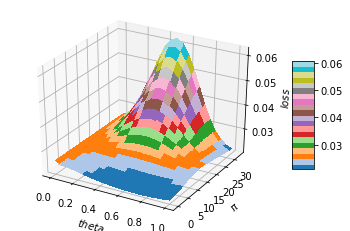

In [71]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.tab20,
                       linewidth=0, antialiased=False)
ax.set_xlabel('$theta$')
ax.set_ylabel('$\pi$')
ax.set_zlabel('$loss$')
# Customize the z axis.
# ax.set_zlim(-1.01, 1.01)
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# ax.view_init(0, 180)
# ax.view_init(0, 0)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.savefig('fig1.png')
plt.show()

<Figure size 432x288 with 0 Axes>

### How much are they similar to each other?

In [214]:
def average_distance(model1, model2):
    w = zip(model1.get_weights(), model2.get_weights())
    lw = list(w)
    sums = 0
    i = 0
    for ww in lw:
        i += 1
        sums += np.average(np.absolute(ww[0] - ww[1]))
    return sums / i

In [215]:
average_distance(model1, model2)

0.05077916461353501

In [209]:
cur_max = 0
i = 0
for ww in lw:
    i += 1
    cur_max = max(np.max(np.absolute(ww[0] - ww[1])), cur_max)

In [210]:
cur_max

0.13698825

In [213]:
import numpy as np
pi_list = list(np.arange(0, 1.05, 0.05)) # P for perturbations

weights = [model1.get_weights(), model2.get_weights()]
model_weights_list = list()
for pi in pi_list:
    agg_weights = list()
    for weights_list_tuple in zip(*weights):
        agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - pi, pi]) for w in zip(*weights_list_tuple)]))
    model_weights_list.append(agg_weights)
    
model_list2 = list()
for _ in range(len(pi_list)):
    model_list2.append(tf.keras.models.clone_model(model1))
    
for i in range(len(model_list)):
    model_list2[i].set_weights(model_weights_list[i])

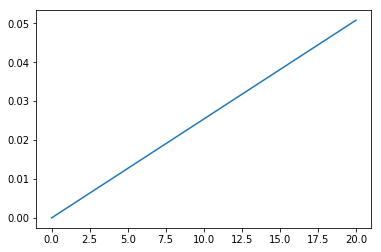

In [217]:
plt.plot([average_distance(model1, m) for m in model_list2])
plt.show()

### backup results

In [ ]:
%tensorboard --logdir logs

In [ ]:
a = 2

## @TODO Experiment with pretrained model

In [159]:
pretrained_model1 = tf.keras.models.clone_model(model1)
pretrained_model2 = tf.keras.models.clone_model(model1)